In [1]:
import sys
sys.path.append('../')
import libs.db
import libs.prep_df
import pandas as pd
import sqlite3

In [2]:
tickers = libs.db.get_tickers("sp10.csv")
num_ticks = 60

In [3]:
sql_file = "sp10_historical.db"
conn = libs.db.create_connection(sql_file)
hist_df = libs.db.df_from_db(conn)
libs.db.close_connection(conn)
hist_df = libs.prep_df.normalize_df(hist_df)

In [4]:
hist_shifted_df = pd.DataFrame()
for ticker in tickers:
    hist_shifted_df[ticker] = hist_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        hist_shifted_df[name] = hist_df[ticker].shift(i)
hist_shifted_df = hist_shifted_df.copy()
hist_shifted_df.shape

ipykernel_launcher:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
ipykernel_launcher:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(17080, 600)

In [5]:
hist_pct_returns_df_list = []
for ticker in tickers:
    name = f"{ticker}_Buy"
    returns_df = pd.DataFrame()
    returns_df[name] = hist_df[ticker].pct_change(periods=16).shift(-16).apply(lambda x : 1 if x >= 0.0075 else 0)
    hist_pct_returns_df_list.append(returns_df)
len(hist_pct_returns_df_list)

10

In [6]:
sql_file = "sp10_current.db"
conn = libs.db.create_connection(sql_file)
current_df = libs.db.df_from_db(conn)
libs.db.close_connection(conn)
current_df = libs.prep_df.normalize_df(current_df)

In [7]:
current_shifted_df = pd.DataFrame()
for ticker in tickers:
    current_shifted_df[ticker] = current_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        current_shifted_df[name] = current_df[ticker].shift(i)
current_shifted_df = current_shifted_df.copy()
current_shifted_df.dropna(inplace=True)

ipykernel_launcher:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
ipykernel_launcher:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [8]:
hist_pctchange_df = hist_shifted_df.pct_change()
hist_pctchange_df = pd.concat([hist_pctchange_df, *hist_pct_returns_df_list], axis=1)
hist_pctchange_df.dropna(inplace=True)
hist_pctchange_df.shape

(17020, 610)

In [9]:
current_pctchange_df = current_shifted_df.pct_change()
current_pctchange_df.dropna(inplace=True)

In [10]:
y_start = len(tickers)*num_ticks

In [11]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [12]:
X = hist_pctchange_df.iloc[:,0:y_start].values
y = []
for i in range(0,len(tickers)):
    y.append(hist_pctchange_df.iloc[:,y_start+i].values)

In [13]:
xgb_models = []
xgb_confusion = []
xgb_classification = []
target_names = ["Not Buy", "Buy"]
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = XGBClassifier(n_estimators=100, random_state=1, use_label_encoder=False, objective="binary:hinge", eval_metric="logloss")
    X_train, X_test, y_train, y_test = train_test_split(X, y[i],random_state=1,stratify=y[i])
    model.fit(X_train,y_train)
    xgb_models.append(model)
    predicted = model.predict(X_test)
    xgb_confusion.append(confusion_matrix(y_test, predicted))
    xgb_classification.append(classification_report(y_test, predicted, target_names=target_names))
    print("--------------------------------------")
    print(ticker)
    print(f"Training Data Score: {model.score(X_train, y_train)}")
    print(f"Testing Data Score: {model.score(X_test, y_test)}")
    print(xgb_confusion[i])
    print(xgb_classification[i])


--------------------------------------
AAPL
Training Data Score: 0.9540148844496671
Testing Data Score: 0.6312573443008226
[[2342  557]
 [1012  344]]
              precision    recall  f1-score   support

     Not Buy       0.70      0.81      0.75      2899
         Buy       0.38      0.25      0.30      1356

    accuracy                           0.63      4255
   macro avg       0.54      0.53      0.53      4255
weighted avg       0.60      0.63      0.61      4255

--------------------------------------
MSFT
Training Data Score: 0.9679592636114375
Testing Data Score: 0.645593419506463
[[2454  527]
 [ 981  293]]
              precision    recall  f1-score   support

     Not Buy       0.71      0.82      0.76      2981
         Buy       0.36      0.23      0.28      1274

    accuracy                           0.65      4255
   macro avg       0.54      0.53      0.52      4255
weighted avg       0.61      0.65      0.62      4255

--------------------------------------
AMZN
Tra

In [14]:
#Predict pct-change for each of the tickers over the month of June 2021
y_current_predicted = []
current_returns_df_list = []
X = current_pctchange_df.values
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = xgb_models[i]
    predicted = model.predict(X)
    y_current_predicted.append(predicted)
    return_df = pd.DataFrame({"timestamp":current_pctchange_df.index, "buy_predicted": predicted})
    return_df = return_df.set_index("timestamp")
    return_df = return_df.merge(current_df[ticker], how="left", on="timestamp")
    print(ticker, return_df["buy_predicted"].sum())

    money = 10000
    num_shares = 0
    state = 0
    buy_index = 0
    money_list=[]

    for i in range(0,len(return_df)):
        if state == 1 and i == buy_index + 16:
            #sell
            price = return_df.iloc[i,1]
            money = num_shares * price
            state = 0
            print(f"sell {ticker}", i ,price)

        if return_df.iloc[i,0] == 1 and state == 0 and i < len(return_df) - 16:
            #buy
            price = return_df.iloc[i,1]
            num_shares = money / price
            buy_index = i
            state = 1
            print(f"buy {ticker}", i, price)

        if return_df.iloc[i,0] == 1 and state == 1 and i < len(return_df) - 16:
            buy_index = i

        if state == 0 :
            money_list.append(money)
        else:
            price = return_df.iloc[i,1]
            money_list.append(num_shares*price)
    
    return_df["ROI"] = money_list

    current_returns_df_list.append(return_df)

AAPL 31
buy AAPL 7 126.15
sell AAPL 74 126.7092
buy AAPL 76 127.0619
sell AAPL 92 129.565
buy AAPL 119 129.86
sell AAPL 156 130.95
buy AAPL 161 130.2099
sell AAPL 228 133.32
buy AAPL 230 133.45
sell AAPL 287 136.92
MSFT 35
buy MSFT 0 250.62
sell MSFT 48 253.36
buy MSFT 54 252.8
sell MSFT 97 259.8
buy MSFT 111 258.52
sell MSFT 227 266.98
buy MSFT 227 266.98
sell MSFT 259 268.45
buy MSFT 273 271.4
sell MSFT 289 270.98
AMZN 45
buy AMZN 0 3205.05
sell AMZN 47 3281.15
buy AMZN 50 3279.85
sell AMZN 86 3358.0
buy AMZN 112 3381.0
sell AMZN 231 3454.0
buy AMZN 233 3408.985
sell AMZN 257 3442.89
buy AMZN 264 3442.61
sell AMZN 280 3444.0
FB 45
buy FB 4 329.01
sell FB 95 336.82
buy FB 112 336.75
sell FB 135 329.0
buy FB 136 329.482
sell FB 195 340.42
buy FB 195 340.42
sell FB 212 342.3
buy FB 214 342.84
sell FB 260 356.4
buy FB 260 356.4
sell FB 290 348.0
GOOGL 29
buy GOOGL 0 2394.0
sell GOOGL 16 2402.3
buy GOOGL 24 2415.1
sell GOOGL 62 2431.8
buy GOOGL 65 2439.0
sell GOOGL 81 2430.53
buy GOOGL 92

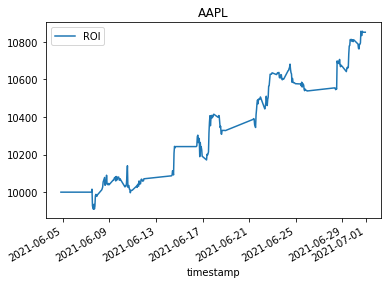

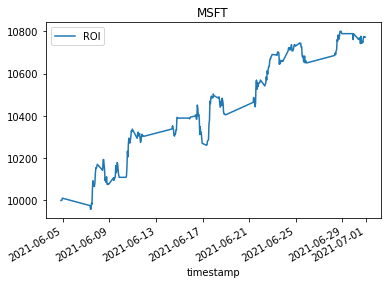

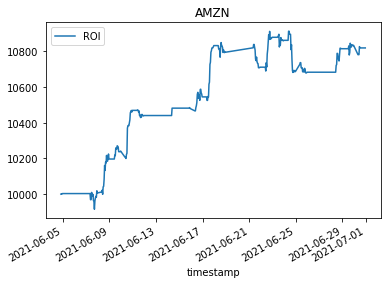

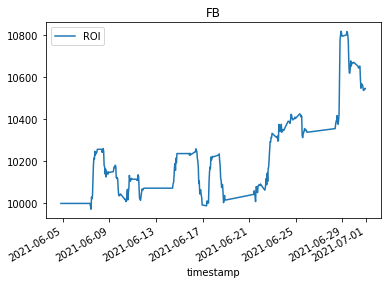

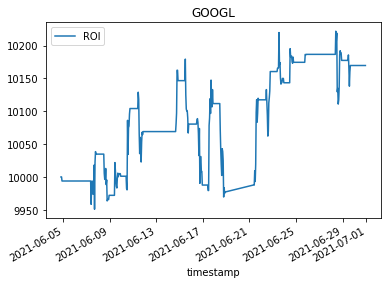

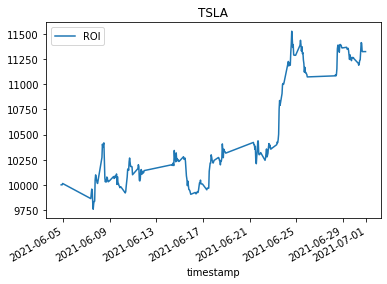

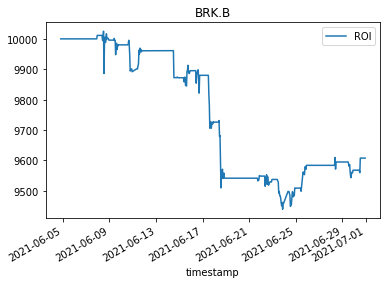

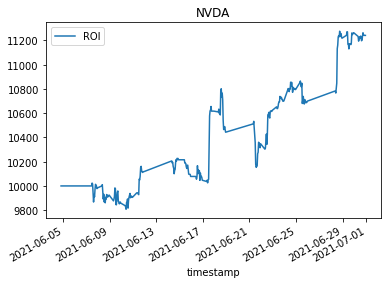

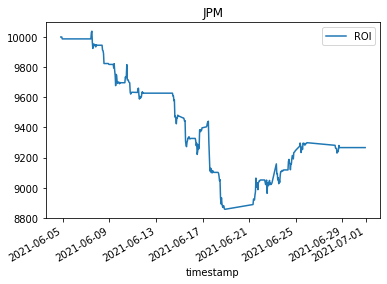

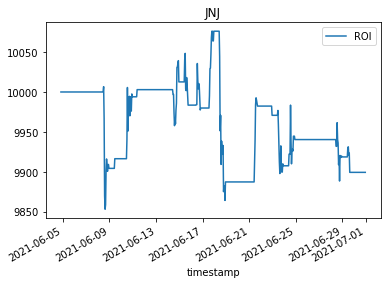

In [15]:
for i in range(0,len(tickers)):
    ticker = tickers[i]
    current_returns_df_list[i].plot(y="ROI", title=ticker)

In [16]:
starting_amount = 10000*len(tickers)
ending_amount = 0
for i in range(0,len(tickers)):
    ending_amount += current_returns_df_list[i].iloc[-1,-1]
ending_amount

104496.08428481614

In [17]:
current_returns_df_list[0]

,buy_predicted,AAPL,ROI
timestamp,,,
2021-06-04 20:00:00+00:00,0,125.98,10000.000000
2021-06-04 21:00:00+00:00,0,125.99,10000.000000
2021-06-04 22:00:00+00:00,0,125.95,10000.000000
2021-06-04 23:00:00+00:00,0,126.01,10000.000000
2021-06-07 08:00:00+00:00,0,125.36,10000.000000
...,...,...,...
2021-06-30 19:00:00+00:00,0,136.92,10849.830773
2021-06-30 20:00:00+00:00,0,136.93,10849.830773
2021-06-30 21:00:00+00:00,0,137.02,10849.830773


In [18]:
print("TOTAL BUY SIGNALS------------")
for i in range(0,len(tickers)):
    print(f"{tickers[i]}: {current_returns_df_list[i]['buy_predicted'].sum()}")

TOTAL BUY SIGNALS------------
AAPL: 31
MSFT: 35
AMZN: 45
FB: 45
GOOGL: 29
TSLA: 62
BRK.B: 23
NVDA: 61
JPM: 39
JNJ: 16


In [19]:
summary_df = current_returns_df_list[0].copy()
summary_df = pd.DataFrame(summary_df["ROI"])
summary_df = summary_df.rename(columns={"ROI": f"XGB_{tickers[0]}"})
for i in range(1,len(tickers)):
    temp_df = current_returns_df_list[i].copy()
    temp_df = pd.DataFrame(temp_df["ROI"])
    temp_df = temp_df.rename(columns={"ROI": f"XGB_{tickers[i]}"})
    summary_df = pd.concat([summary_df, temp_df], axis=1)
summary_df.to_csv("xgb_roi.csv")